# Deploying ML Models using MLFlow and Sklearn Pipeline

This notebook is demostrated how to use MLflow and Sklearn to deploy ML models into production. 
MLFlow and Sklearn are very virsetile frameworks and there are multiple ways to deploy ML models with them. 
In this notebook I choose to demotrate a pragmatic 


In [42]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient

from numpy import savetxt
from json import JSONEncoder

import requests
import curl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import os

import mlflow
import mlflow.sklearn


In [3]:
""" Use the house prices dataset for this studynote """

source_dataset = pd.read_csv("../data/House_Price.csv", header=0)

In [4]:
def minimize_dataset(df):
    """ 
    Return a minimized version of the data, 
    to make easy to expirement with feature transformation 
    """

    new_df = pd.DataFrame()

    new_df['price'] = df.price

    # Add new number of hotel rooms to the new df
    new_df['n_hot_rooms'] = df.n_hot_rooms
    
    # Filling missing value in n_hos_beds
    new_df['n_hos_beds'] = df.n_hos_beds

    # Transform the inversely proportional functoin into a liner function using log
    new_df['crime_rate'] = df.crime_rate

    new_df['room_num'] = df.room_num
    new_df['teachers'] = df.teachers
    new_df['waterbody'] = df.waterbody

    new_df['dist1'] = df.dist1
    new_df['dist2'] = df.dist2
    new_df['dist3'] = df.dist3
    new_df['dist4'] = df.dist4
    
    # Convert categorical variables to dummy variables
    #new_df = pd.get_dummies(new_df, drop_first=True)

    return new_df

## Exloring the Data

In [5]:
source_dataset.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,YES,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,YES,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,None,38,YES,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,YES,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,YES,0.039474


#### Minimize the data to simplify the examples

In [6]:
df = minimize_dataset(source_dataset)
df.head()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
0,24.0,11.1920,5.480,0.00632,6.575,24.7,River,4.35,3.81,4.18,4.01
1,21.6,12.1728,7.332,0.02731,6.421,22.2,Lake,4.99,4.70,5.12,5.06
2,34.7,101.1200,7.394,0.02729,7.185,22.2,None,5.03,4.86,5.01,4.97
3,33.4,11.2672,9.268,0.03237,6.998,21.3,Lake,6.21,5.93,6.16,5.96
4,36.2,11.2896,8.824,0.06905,7.147,21.3,Lake,6.16,5.86,6.37,5.86


### Data Overview
Notes:
- Hospital beds have missing data.
- The distance from employment centers (dist1, dist2...) is similar
- Hi standard diviation for crime_rate
- Waterboy is not numerical

In [7]:
df.describe()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,dist1,dist2,dist3,dist4
count,506.000000,506.000000,498.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.528854,13.041605,7.899767,3.613524,6.284634,21.544466,3.971996,3.628775,3.960672,3.618972
std,9.182176,5.238957,1.476683,8.601545,0.702617,2.164946,2.108532,2.108580,2.119797,2.099203
min,5.000000,10.057600,5.268000,0.006320,3.561000,18.000000,1.130000,0.920000,1.150000,0.730000
25%,17.025000,11.189800,6.634500,0.082045,5.885500,19.800000,2.270000,1.940000,2.232500,1.940000
50%,21.200000,12.720000,7.999000,0.256510,6.208500,20.950000,3.385000,3.010000,3.375000,3.070000
75%,25.000000,14.170800,9.088000,3.677083,6.623500,22.600000,5.367500,4.992500,5.407500,4.985000
max,50.000000,101.120000,10.876000,88.976200,8.780000,27.400000,12.320000,11.930000,12.320000,11.940000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        506 non-null    float64
 1   n_hot_rooms  506 non-null    float64
 2   n_hos_beds   498 non-null    float64
 3   crime_rate   506 non-null    float64
 4   room_num     506 non-null    float64
 5   teachers     506 non-null    float64
 6   waterbody    506 non-null    object 
 7   dist1        506 non-null    float64
 8   dist2        506 non-null    float64
 9   dist3        506 non-null    float64
 10  dist4        506 non-null    float64
dtypes: float64(10), object(1)
memory usage: 43.6+ KB


In [9]:
# Prep the data for training and prediction
if 'price' in df: 
    y = df.pop('price')


In [30]:
# Shortcut functions 

def get_training_testing_data():
    """Function to simplify data splitting"""
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def eval_metrics(y_true , y_pred):
    """Function to simplfy metrics evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

## Feature Engineering

### Custom Transfromer Class Concat Columns into One Average Column

In [11]:
class ColumnAvgTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,columns, new_column_name):
        self.columns = columns
        self.new_column_name = new_column_name
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.new_column_name] = X[self.columns].mean(axis=1)
        X = X.drop(self.columns, axis=1)
        return X
    

### Feature Engineering Using SKLearn ColumnTransformer 

In [28]:
## Feature preprocessing

numeric_features = ['n_hot_rooms','n_hos_beds','room_num','teachers']
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='mean')), ## Fill null cell with mean of the series 
     ('scaler', StandardScaler())])

categorical_features = [ 'waterbody']
categorical_transformer = Pipeline(steps=[ 
     ('imputer', SimpleImputer(strategy='constant',fill_value=0)), ## Fill null cell with 0
     ('ordinal_encoder', preprocessing.OrdinalEncoder())]) ## Encode categorical values (Lake = 1, Ocean = 2...)

log_features = ['crime_rate']
log_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='median')),
     ('log_tranformer', FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one'))
])

"""
The remainder passthrough let columns that are not specified 
in the ColumnTransfer passthrough 
""" 
preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features),
          ('log', log_transformer, log_features)
          ], 
          remainder='passthrough'
     )

preprocessor.set_output(transform="pandas")


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['n_hot_rooms', 'n_hos_beds', 'room_num',
                                  'teachers']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 ['waterbody']),
                                ('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log_tranformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      validate=True))]),
                                 ['crime_rate'])])

### Training and Evaluating Model without MLFlow
The following cell is an example of the transient nature of model development. 
When a hyperparam changes, the param, and metrics are transient until the following change and run. 

[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.7s
MAE: 2.37, RMSE: 3.29


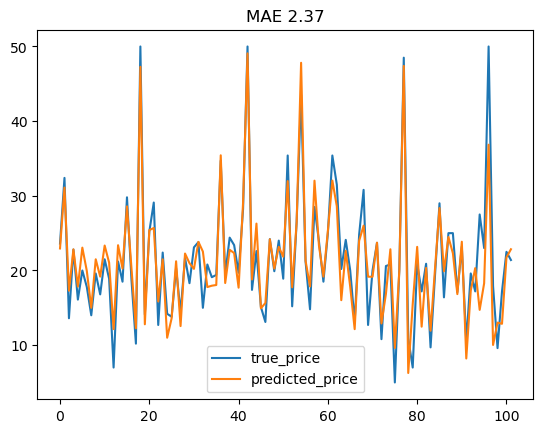

In [19]:
X_train, X_test, y_train, y_test = get_training_testing_data()

params = {'max_depth':13, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.7, 'colsample_bytree':0.8}
model = Pipeline(steps=[
    ('avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')),
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBRegressor(**params))
    ], verbose=True)


model.fit(X_train, y_train)

predictions = model.predict(X_test)
rmse, mae, r2 = eval_metrics(y_pred = predictions, y_true= y_test)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

compare = pd.DataFrame({0:y_test.values, 1:predictions })
compare.columns=['true_price', 'predicted_price']
fig = compare.plot(use_index=True, title = f"MAE {mae:.2f}").get_figure()
fig_file = "true_vs_predicted.png"
fig.savefig(fig_file)

### Deeper Look into Pipeline
Notice that the ML model (classifier) is the last step in a Pipeline. 
A pipeline is a SKLearn class that chain data transformer and classifiers. 
It enables us to package everything needed to run the model. 
This will be useful later on when we deploy this model into production

This pipeline have three steps:
1. 'avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')
2. 'preprocessor', preprocessor 
3. 'classifier', xgb.XGBRegressor(**params)

In [34]:
## Data before entering the pipeline
X_train.head()

,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4,avg_dist
477,15.0960,9.340,15.02340,5.304,19.8,Lake,2.28,1.99,2.41,1.73,2.1025
15,14.1592,8.498,0.62739,5.834,19.0,River,4.60,4.35,4.72,4.32,4.4975
332,14.1552,7.488,0.03466,6.031,23.1,None,6.95,6.58,6.80,6.23,6.6400
423,81.1200,8.268,7.05042,6.103,19.8,Lake,2.08,1.80,2.34,1.87,2.0225
19,12.1456,8.564,0.72580,5.727,19.0,Lake and River,3.98,3.65,4.00,3.57,3.8000


In [35]:
## Data looks after first step. Notice the new avg_dist column 
model[0:1].fit_transform(X_train)

[Pipeline]  (step 1 of 1) Processing avg_dist_transformer, total=   0.0s


,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,avg_dist
477,15.0960,9.340,15.02340,5.304,19.8,Lake,2.1025
15,14.1592,8.498,0.62739,5.834,19.0,River,4.4975
332,14.1552,7.488,0.03466,6.031,23.1,None,6.6400
423,81.1200,8.268,7.05042,6.103,19.8,Lake,2.0225
19,12.1456,8.564,0.72580,5.727,19.0,Lake and River,3.8000
...,...,...,...,...,...,...,...
106,14.1560,10.290,0.17120,5.836,19.1,Lake,2.2100
270,15.1688,6.222,0.29916,5.856,21.4,None,4.4300
348,13.1960,6.290,0.01501,6.635,23.0,None,8.3425
435,12.1072,10.168,11.16040,6.629,19.8,Lake and River,2.1250


In [36]:
## Data after the second step. Nutice the numeric values are scaled and categorical (waterbody) data is numeric
model[0:2].fit_transform(X_train)

[Pipeline]  (step 1 of 2) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing preprocessor, total=   0.0s


,num__n_hot_rooms,num__n_hos_beds,num__room_num,num__teachers,cat__waterbody,log__crime_rate,remainder__avg_dist
477,0.592920,0.958632,-1.428069,-0.845343,0.0,2.774050,2.1025
15,0.345531,0.383383,-0.680087,-1.204741,3.0,0.486978,4.4975
332,0.344475,-0.306642,-0.402063,0.637176,2.0,0.034073,6.6400
423,18.028479,0.226249,-0.300450,-0.845343,0.0,2.085724,2.0225
19,-0.186219,0.428474,-0.831094,-1.204741,1.0,0.545691,3.8000
...,...,...,...,...,...,...,...
106,0.344686,1.607666,-0.677264,-1.159817,0.0,0.158029,2.2100
270,0.612145,-1.171565,-0.649038,-0.126546,2.0,0.261718,4.4300
348,0.091170,-1.125108,0.450354,0.592251,2.0,0.014898,8.3425
435,-0.196359,1.524317,0.441886,-0.845343,1.0,2.498185,2.1250


## Tracking Expirements with MLFlow

In [37]:
## Setting global variables
MODEL_ARTIFACTS_PATH = "skl_pipe_xgb_house_prices_path"
EXPERIMENT_NAME = "exp_3_house_prices_sklearn_pipe_xgb"

## Tell MLFlow where is the tracking server
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("experiment_id:", experiment.experiment_id)


experiment_id: 14


[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.6s


/home/eliran/.local/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/22 17:24:24 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 34
Created version '34' of model 'house_prices_xgb_model'.


run_uri - runs:/d0312261185a4f498c88105e4f15c27f MAE: 2.3715419011957506
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.6s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/22 17:24:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 35
Created version '35' of model 'house_prices_xgb_model'.


run_uri - runs:/22570f9da54a43e889ffb8f075acd3c6 MAE: 2.2197024784836112
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.3s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/22 17:24:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 36
Created version '36' of model 'house_prices_xgb_model'.


run_uri - runs:/7a83099a09c149c889f4b85025d7f0ce MAE: 3.080276022705377
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.2s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/22 17:24:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 37
Created version '37' of model 'house_prices_xgb_model'.


run_uri - runs:/6407aef660b0414bb78734648af78220 MAE: 3.4597168562459006


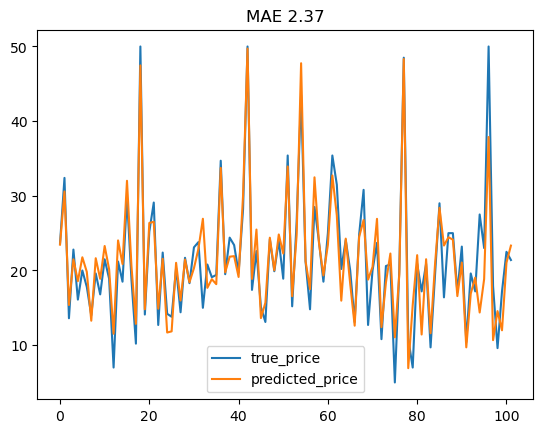

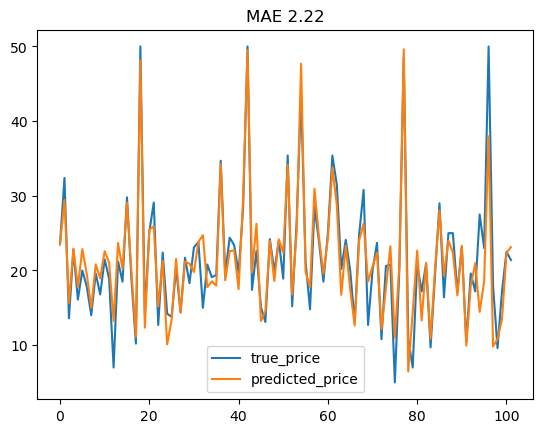

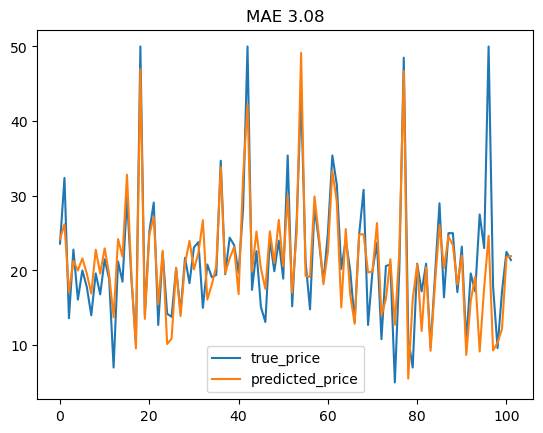

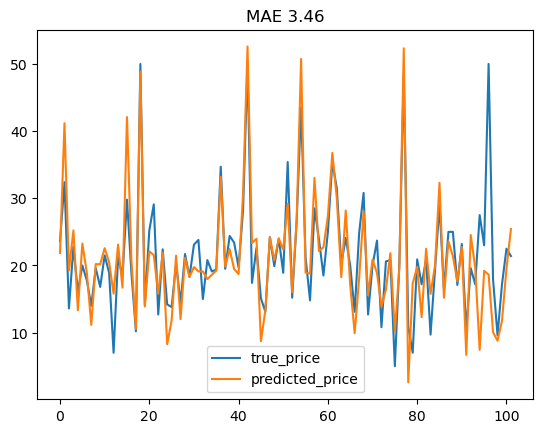

In [38]:
## Get Training Data
X_train, X_test, y_train, y_test = get_training_testing_data()

# List of different hyperparams to expirement. This is pretty manual example for the purpose to demotrating how the different
# runs hyperparams looks like in the mlflow UI. 
params_list = [
    {'max_depth':20, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':1.0, 'colsample_bytree':0.8},
    {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8},
    {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.5, 'subsample':0.8, 'colsample_bytree':0.8},
    {'max_depth':12, 'n_estimators':1000, 'learning_rate':1.0, 'subsample':0.8, 'colsample_bytree':0.8}
]

for params in params_list:
    with mlflow.start_run() as model_tracking_run:

        """ 
        Log model params in MLFlow
        Example of param dict: {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8}
        """
        mlflow.log_params(params)

        """
        The pipeline is composed of three parts. 
        1. Custom transformer that modify the shape of the dataframe.
        2. Preprocesor that generate features by filling null values and replace categorical values with numbers
        3. The estimator model
        Git notebook on github for the preprocessor and transformer code
        """
        model = Pipeline(steps=[
            ('avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')),
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBRegressor(**params))
        ], verbose=True)
        
        # Fit execute the transformer, preprocessor and estimator 
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        # mlflow generates the model signtur. What paramaters the model expects, and what does it return. 
        model_signature = infer_signature(X_train, predictions)

        ## Log model in MLFlow - registered_model_name = "house_prices_xgb_model"
        mlflow.sklearn.log_model(sk_model = model, 
            artifact_path=MODEL_ARTIFACTS_PATH,
            registered_model_name = "house_prices_xgb_model",
            signature = model_signature)

        rmse, mae, r2 = eval_metrics(y_test, predictions)

        # log model performance
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Print the run id
        run_uri = f"runs:/{model_tracking_run.info.run_id}"
        print(f"run_uri - {run_uri} MAE: {mae}")

        # Store run artifacts in the local file system and log into the tracking server
        # This creates /path/where/notebook/run/artifacts_store/run_0287c883ffdc406bbffa91b5eef156dc
        local_artifacts_store_path = f"artifacts_store/run_{model_tracking_run.info.run_id}"
        os.makedirs(local_artifacts_store_path)

        ## Save and log predicted values
        prediction_file = f"{local_artifacts_store_path}/prediction.csv"
        savetxt(prediction_file, predictions)
        mlflow.log_artifact(prediction_file)

        ## Create a plot that shows predicted vs true prices
        compare = pd.DataFrame({0:y_test.values, 1:predictions })
        compare.columns=['true_price', 'predicted_price']
        fig = compare.plot(use_index=True, title = f"MAE {mae:.2f}").get_figure()
        fig_file = f"{local_artifacts_store_path}/true_vs_predicted.png"
        fig.savefig(fig_file)
        mlflow.log_artifact(fig_file)

        """
        Example of finel run artifacts on the file system
        ls -l /path/where/notebook/run/artifacts_store/run_0287c883ffdc406bbffa91b5eef156dc
        prediction.csv
        true_vs_predicted.png
        """




In [44]:
client = MlflowClient()

def get_model_metadata(model_name: str, stage: str) -> dict:
    """ Function to find the model version and return key metadata"""
    mv = client.get_latest_versions(name=model_name, stages=[stage])
    if len(mv) == 1:
        mv = mv[0]
        meta = dict()
        meta['stage'] = mv.current_stage
        meta['model_name'] = mv.name
        meta['model_version'] = mv.version
        meta['model_uri'] = f"models:/{model_name}/{stage}"
        return meta

    else:
        print(f"Can't find model version for {model_name} state {stage}")
        return None

In [40]:

def write_bash_deployment_script(model_name, stage, port) -> dict:
    meta = get_model_metadata(model_name, stage)
    filename = f"deploy_{model_name}_to_{stage}.sh"
    model_uri = meta['model_uri']

    with open(filename, 'w') as f:
        f.write('#!/bin/bash\n\n')
        f.write('export MLFLOW_TRACKING_URI=http://localhost:5000\n')
        f.write(f'mlflow models serve -m "{model_uri}" -p {port}\n')
    
    meta['deployment_script'] = filename

    return meta


In [45]:
meta = write_bash_deployment_script('house_prices_xgb_model', 'Production', 8002)

print(meta)

{'stage': 'Production', 'model_name': 'house_prices_xgb_model', 'model_version': '31', 'model_uri': 'models:/house_prices_xgb_model/Production', 'deployment_script': 'deploy_house_prices_xgb_model_to_Production.sh'}


In [46]:
def test_model_deployment(meta: dict, port: int, test_df: pd.DataFrame):
    host = '0.0.0.0'
    
    url = f'http://{host}:{port}/invocations'
    headers = {
        'Content-Type': 'application/json',
    }
    http_data = test_df.to_dict('r')

    payload = JSONEncoder().encode({"dataframe_records": [http_data[0]]})

    response = requests.post(url=url, headers=headers, data=payload)

    if response.status_code == 200:
        print(f'Predictions: {response.text}')

        curl_string = curl.parse(response, return_it=True)
        client.update_model_version(
            name = meta['model_name'],
            version = meta['model_version'],
            current_stage = meta['stage']
            description = f"Model is in production.\n Example of curl calling it:\n\n {curl_string}",
        )
    else:
        print("Something didn't work :(")

In [48]:
test_model_deployment(meta, 8002, X_test)

/tmp/ipykernel_13955/1482615355.py:8: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  http_data = test_df.to_dict('r')


Predictions: {"predictions": [23.44147300720215]}
curl -X POST -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate, br' -H 'Connection: keep-alive' -H 'Content-Type: application/json' -H 'User-Agent: python-requests/2.28.1' -d '{"dataframe_records": [{"n_hot_rooms": 10.1888, "n_hos_beds": 9.872, "crime_rate": 0.09178, "room_num": 6.416, "teachers": 23.4, "waterbody": "None", "dist1": 2.86, "dist2": 2.57, "dist3": 2.77, "dist4": 2.39, "avg_dist": 2.6475}]}' http://0.0.0.0:8002/invocations


In [49]:

# test_data is a Pandas dataframe with data for testing the ML model


x = JSONEncoder().encode({"dataframe_split": http_data})
print(x)

r = requests.post(url=url, headers=headers, data=x)

print(f'Predictions: {r.text}')
curl_string = curl.parse(r, return_it=True)
print(curl_string)




NameError: name 'http_data' is not defined

In [37]:
host = '0.0.0.0'
port = '8001'

url = f'http://{host}:{port}/invocations'

print(url)
headers = {
    'Content-Type': 'application/json',
}

# test_data is a Pandas dataframe with data for testing the ML model
http_data = X_test.to_dict('r')

x = JSONEncoder().encode({"dataframe_records": [http_data[0]]})
print(x)

r = requests.post(url=url, headers=headers, data=x)

print(f'Predictions: {r.text}')

http://0.0.0.0:8001/invocations
{"dataframe_records": [{"n_hot_rooms": 10.1888, "n_hos_beds": 9.872, "crime_rate": 0.09178, "room_num": 6.416, "teachers": 23.4, "waterbody": "None", "dist1": 2.86, "dist2": 2.57, "dist3": 2.77, "dist4": 2.39, "avg_dist": 2.6475}]}
Predictions: {"predictions": [23.44147300720215]}


/tmp/ipykernel_151632/1419877898.py:12: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  http_data = X_test.to_dict('r')


In [39]:
host = '0.0.0.0'
port = '8001'

url = f'http://{host}:{port}/ping'

headers = {
    'Content-Type': 'application/json',
}

r = requests.get(url=url, headers=headers)

print(r.status_code)

200


In [20]:
from pprint import pprint
from mlflow import MlflowClient

mlflow.set_tracking_uri('http://localhost:5000')

client = MlflowClient()
for rm in client.search_registered_models():
    pprint(dict(rm), indent=4)

{   'creation_timestamp': 1677505289106,
    'description': '',
    'last_updated_timestamp': 1677506861344,
    'latest_versions': [   <ModelVersion: creation_timestamp=1677505289239, current_stage='Staging', description='', last_updated_timestamp=1677506861344, name='HousePrices_Model_A', run_id='123224b04e3748a6a79f4ae615902225', run_link='', source='mlflow-artifacts:/2/123224b04e3748a6a79f4ae615902225/artifacts/preprocess_and_xgb', status='READY', status_message='', tags={'task': 'deploy'}, user_id='', version='1'>,
                           <ModelVersion: creation_timestamp=1677506774841, current_stage='None', description='', last_updated_timestamp=1677506774841, name='HousePrices_Model_A', run_id='2f72025b8d63454b8cdddd034107ca2f', run_link='', source='mlflow-artifacts:/2/2f72025b8d63454b8cdddd034107ca2f/artifacts/preprocess_and_xgb', status='READY', status_message='', tags={}, user_id='', version='2'>],
    'name': 'HousePrices_Model_A',
    'tags': {}}
{   'creation_timestamp'

In [94]:
client.search_registered_models()[0].latest_versions[0].current_stage

'Staging'

In [96]:
for x in client.search_registered_models():
    for v in x.latest_versions:
        if(v.current_stage == 'Production'):
            print(v)


<ModelVersion: creation_timestamp=1678291325423, current_stage='Production', description='', last_updated_timestamp=1678802611916, name='house_prices_xgb_model', run_id='b49fecb8dddd4b338589019620d9e391', run_link='', source='mlflow-artifacts:/13/b49fecb8dddd4b338589019620d9e391/artifacts/skl_pipe_xgb_house_prices_path', status='READY', status_message='', tags={'workflow_status': 'ready_to_deploy'}, user_id='', version='26'>
<ModelVersion: creation_timestamp=1678200149223, current_stage='Production', description='', last_updated_timestamp=1678200185239, name='house_prices_xgb_model_2', run_id='b30684b9988d4ac9922e7951cb917285', run_link='', source='mlflow-artifacts:/13/b30684b9988d4ac9922e7951cb917285/artifacts/skl_pipe_xgb_house_prices_path', status='READY', status_message='', tags={}, user_id='', version='2'>


In [24]:
mod = client.get_latest_versions(name='house_prices_xgb_model', stages=['Production'])
stage = mod[0].current_stage
model_name = mod[0].name
model_version = mod[0].version
model_uri = f"models:/{model_name}/{stage}"


In [25]:
model = mlflow.pyfunc.load_model(model_uri=model_uri)

In [40]:
model._model_meta.signature

inputs: 
  ['n_hot_rooms': double, 'n_hos_beds': double, 'crime_rate': double, 'room_num': double, 'teachers': double, 'waterbody': string, 'dist1': double, 'dist2': double, 'dist3': double, 'dist4': double, 'avg_dist': double]
outputs: 
  [Tensor('float32', (-1,))]

In [27]:
print(model_uri)

models:/house_prices_xgb_model/Production


In [32]:

mlflow models serve --model-uri runs:/a00a3ca187b943c4bdb644787bd6b277/model
mlflow models serve --model-uri models:/house_prices_xgb_model/Production

In [40]:
y_pred = pd.Series(data =predictions, name="Predicted_Price")

In [59]:
compare = pd.DataFrame(np.hstack((y_pred[:, None], y_test[:, None])))

/tmp/ipykernel_415888/2907599412.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  compare = pd.DataFrame(np.hstack((y_pred[:, None], y_test[:, None])))


In [68]:
compare = pd.DataFrame({0:y_test.values, 1:predictions })
compare.columns=['true_price', 'predicted_price']

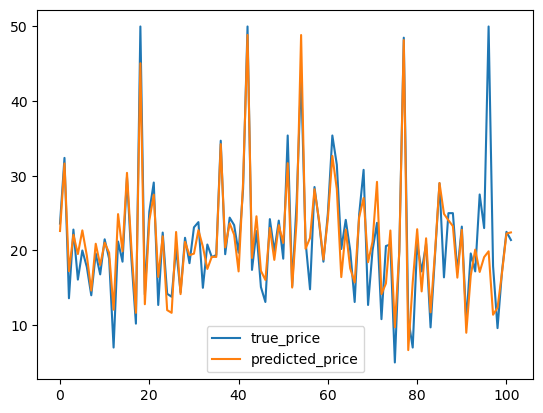

In [76]:
fig = compare.plot(use_index=True).get_figure()
xf = 1234
fig.savefig(f"some_file_{xf}.png")